# Evaluation of Molecular Dynamics Named Entities Recognition (MDNER)

The objective of this notebook is to evaluate our MDNER obtained with [SpaCy v3](https://spacy.io/) by evaluate the annotated entities, the different models and their performance. 

## Prerequise packages

In [39]:
import pandas as pd
import spacy
from matplotlib import pyplot as plt
import os
import seaborn as sns
import json
import glob
from spacy.training import Example
import re

## Corpus composition

The evaluation of the distribution of entities in our corpus will allow us to identify the most and least abundant entities.

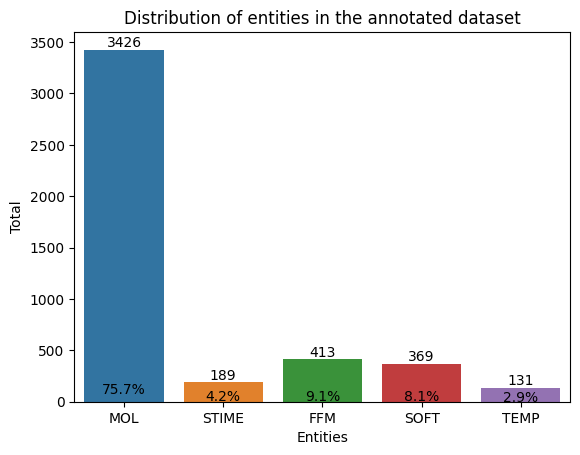

In [40]:
path = "../annotations/"
name_ents = ["MOL", "STIME", "FFM", "SOFT", "TEMP"]
n_ents = {label: 0 for label in name_ents}
total = 0

# Get numbers and percentage for each entity
for json_name in glob.glob(path + "*.json"):
    with open(json_name) as json_file:
        annotations = json.load(json_file)["annotations"][0][1]
        for _, _, label in annotations["entities"]:
            n_ents[label] += 1
            total += 1

# Create a pandas DataFrame with the percentage and total number of sample entities.
df = pd.DataFrame.from_dict(
    {"Percentage": {label: n_ents[label] / total * 100 for label in name_ents},
     "Total": n_ents}
)

# Display a bar plot for each entity
ax = sns.barplot(x=df.index, y='Total', data=df)
plt.xlabel("Entities")
plt.title("Distribution of entities in the annotated dataset")

# Add the number of sample entities and a percentage for each dedicated bar
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{int(df.iloc[i]['Total'])}",
            ha='center',
            va='bottom')
    ax.text(i, df.iloc[i]['Percentage'] + 1,
            f"{df.iloc[i]['Percentage']:.1f}%",
            ha='center')

As shown in the figure above, there is a large number of "MOL" (molecules) entities which represent more than 76% of all entities. The entities "STIME" (simulation time) and "TEMP" (temperature) are less present in the corpus with a percentage of 4.2% and 2.9% respectively. 

In order to learn each entities, more than 100 entities samples must be present. In our case, this condition is correct.

The distribution of these entities allows us to say that the NER should expect an overrepresentation of the entitie "MOL" in a text compared to the entities "STIME" and "TEMP" for example.

We then split our dataset into 3 parts with 75% of the data for the training (251 in total), 15% of the data for the testing (55 in total) and 10% of the data for the evaluation (35 in total).  

## Naive SpaCy model vs. model with a Transformers-type architecture 

In order to obtain the best possible model, we have looked to create different models. We first created two types of models, a statistical model proposed by SpaCy and a model with a Transformers type architecture. Note here that the vectorisation of tokens by the naive model is based on the use of tok2vec. 

In order to evaluate the performance of our models, we will base on 3 metrics, namely the precision score, the recall score and the f1 score:
* Precison score tells us that the model predicts correctly but not everything.
* Recall score tells us that the model predicts many entities but not necessarily correct.
* F1 score is a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision score and the recall score.

These scores are obtained with the help of a confusion matrix and using the formulas available [here](https://en.wikipedia.org/wiki/F-score).
For the evaluation of our model, we will use the precision score as we prefer quality to quantity.

The hyperparameters used to design these models are: 
* *Batch size* of 32
* *Learning rate* of 0.001
* For the model with a Transformers-type architecture, we choose to fine-tune a model which is [*allenai/biomed_roberta_base*](https://huggingface.co/allenai/biomed_roberta_base)

In [41]:
#--------------------------Define functions to get the scores and plot them--------------------------#

def get_scores(paths):
    # Define metrics to plot
    metrics = ["ENTS_F", "ENTS_P", "ENTS_R"]
    
    # Define lists to store scores, loss values and epochs
    results = []
    
    # Loop over paths to extract metrics and loss values
    for path in paths:
        with open(path, "r") as f:
            scores = {metric: [] for metric in metrics}
            loss_validation = []
            epoch = []
            for line in f:
                if line.strip()[0].isdigit():
                    epoch.append(int(line.split()[0]))
                    scores["ENTS_F"].append(float(line.split()[-4]))
                    scores["ENTS_P"].append(float(line.split()[-3]))
                    scores["ENTS_R"].append(float(line.split()[-2]))
                    loss_validation.append(float(line.split()[3]))
            results.append({"epoch": epoch, "scores": scores, "loss_validation": loss_validation})
    return results

def display_plots(results, names_model):            
    # Create plots for metrics and loss evolution
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for i, result in enumerate(results):
        # Create a plot for metrics evolution
        df_scores = pd.DataFrame.from_dict(result["scores"])
        df_scores["epoch"] = result["epoch"]
        title = "only MOL model" if i == 0 else "all entities model"
        sns.lineplot(x="epoch", y="value", hue="variable", data=pd.melt(df_scores, ["epoch"]), ax=axs[0][i])
        axs[0][i].set_title("Metrics evolution of " + names_model[i])
        axs[0][i].set_xlabel("Epoch")
        axs[0][i].set_ylabel("Scores (%)")
        axs[0][i].set_ylim(top=100)

        # Create a plot for loss evolution
        df_loss = pd.DataFrame({"epoch": result["epoch"], "loss_validation": result["loss_validation"]})
        sns.lineplot(x="epoch", y="loss_validation", data=df_loss, ax=axs[1][i])
        axs[1][i].set_title("Loss evolution of " + names_model[i])
        axs[1][i].set_xlabel("Epoch")
        axs[1][i].set_ylabel("Loss value")

### During the training

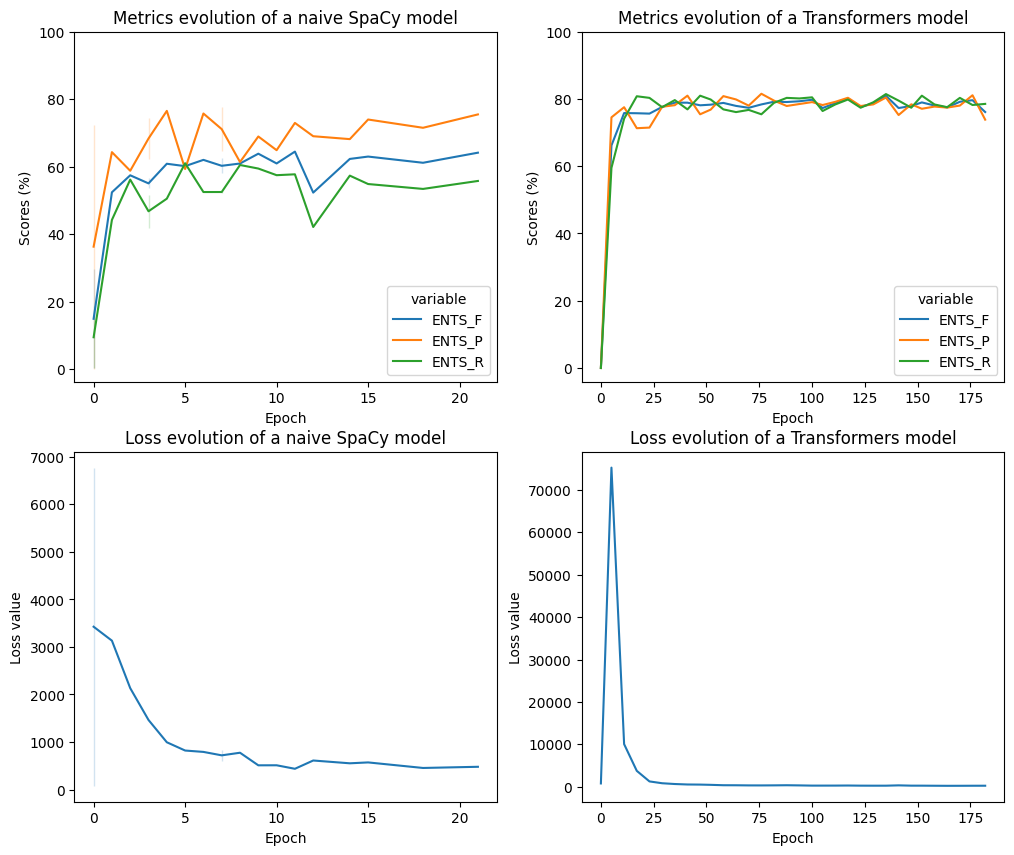

In [48]:
paths = ["../results/models_0.1_1.0_0.0_0.0/metrics_train.txt", "../results/colab/all_ents/metrics_train.txt"]
names_model = ["a naive SpaCy model", "a Transformers model"]
results = get_scores(paths)
display_plots(results, names_model)

From the figures above, we can see that the model with a Transfromers performs better during training. Indeed, all the metrics of the Transformers model are around 80%, whereas the metrics of the naive model are less good. The precision score is around 75%, the recall score is lower with a score of around 50%. We note a difference in the loss value with a better loss value with the Transformers model.

### Benchmark with the evaluation data

In [46]:
!python -m spacy benchmark accuracy ../results/models_0.1_1.0_0.0_0.0/model-best/ ../results/outputs/eval_data.spacy
!python -m spacy benchmark accuracy ../results/colab/all_ents/models/model-best/ ../results/outputs/eval_data.spacy

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   65.18 
NER R   48.23 
NER F   55.43 
SPEED   5857  


=============================== NER (per type) ===============================

            P       R       F
FFM     58.49   58.49   58.49
MOL     69.38   48.01   56.75
TEMP    45.45   45.45   45.45
SOFT    68.18   34.09   45.45
STIME   44.44   61.54   51.61

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   82.38 
NER R   81.80 
NER F   82.09 
SPEED   682   


=============================== NER (per type) ===============================

            P       R       F
FFM     86.96   75.47   80.81
MOL     84.26   85.10   84.68
SOFT    74.36   65.91   69.88
TEMP    66.67   90.91   76.92
STIME   66.67   76.92   71.43



We then tested the two models on a dataset that was not used for the training. The output illustrates what has been said before,  i.e. that the Transformers model performs better. The precision score obtained with the naive model is 65% and the precision score obtained with the Transformers model is 82%.

Thus, through the evaluation of these models, we have chosen to take the Transformers model which has better results.

## Models on the MOL entity

For the next part of the model building, we have chosen to compare two models, namely a model with only the MOL entity and a model with all entities. The MOL entity corresponds to the most important entity, which is why we create a specific model for this entity. We want to verify that the model with only MOL entity has a better performance in terms of classification.

### During the training

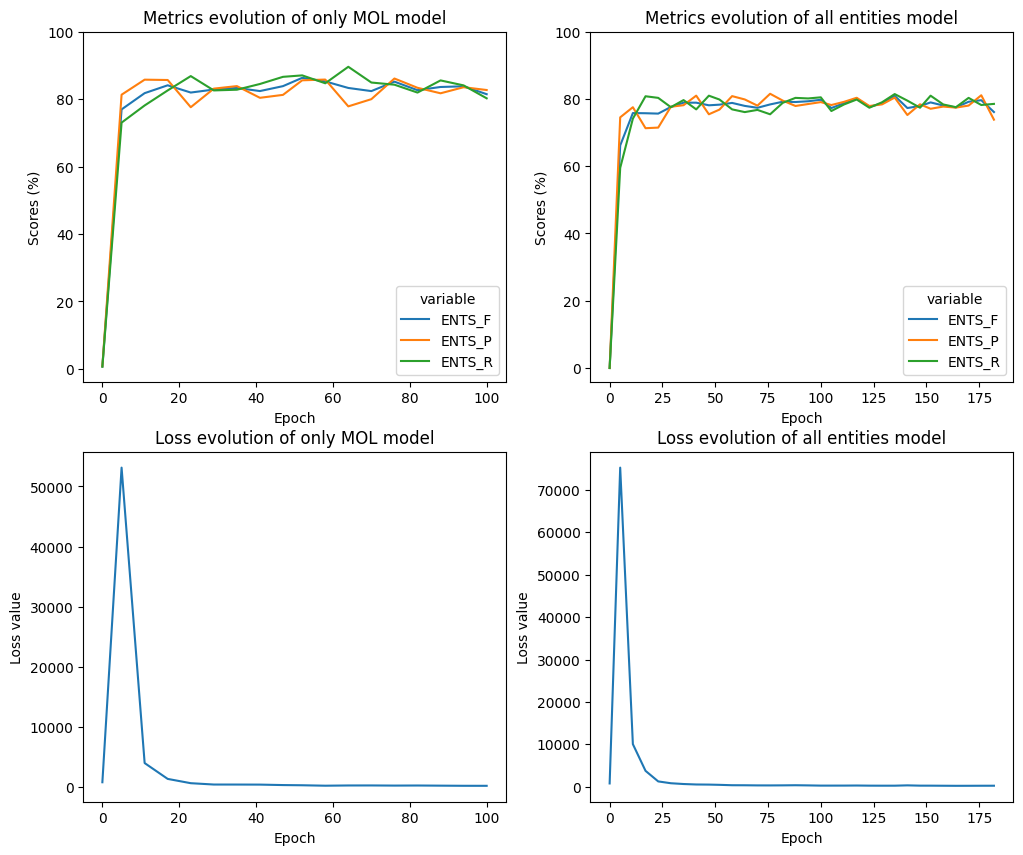

In [47]:
paths = ["../results/colab/only_mol/metrics_train.txt", "../results/colab/all_ents/metrics_train.txt"]
names_model = ["only MOL model", "all entities model"]
results = get_scores(paths)
display_plots(results, names_model)

When designing the models, the resulting model metrics are better on the model with only MOL entities with a difference about 4% for the precision score, 7% for the recall score and 5% for the f1 score.

### Benchmark

In [51]:
!python -m spacy benchmark accuracy ../results/colab/only_mol/models/model-best/ ../results/outputs/eval_data.spacy
!python -m spacy benchmark accuracy ../results/colab/all_ents/models/model-best/ ../results/outputs/eval_data.spacy

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   85.62 
NER R   61.94 
NER F   71.88 
SPEED   696   


=============================== NER (per type) ===============================

            P       R       F
MOL     85.62   86.75   86.18
TEMP     0.00    0.00    0.00
FFM      0.00    0.00    0.00
SOFT     0.00    0.00    0.00
STIME    0.00    0.00    0.00

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK     100.00
NER P   82.38 
NER R   81.80 
NER F   82.09 
SPEED   623   


=============================== NER (per type) ===============================

            P       R       F
FFM     86.96   75.47   80.81
MOL     84.26   85.10   84.68
SOFT    74.36   65.91   69.88
TEMP    66.67   90.91   76.92
STIME   66.67   76.92   71.43



In [52]:
#--------------------------Define functions to get the confusion matrix--------------------------#

def get_entities(doc, only_mol):
    ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    if only_mol:
        ents = [ent for ent in ents if ent[3] == "MOL"]
    return ents

def get_confusion_matrix(name_model, only_mol):
    path = f"../results/colab/{name_model}"
    ner = spacy.load(f"{path}/models/model-best/")
    with open(f"{path}/eval_data.spacy", "rb") as f:
        doc_bin = spacy.tokens.DocBin().from_bytes(f.read())
    tp, fp, fn, tn = 0, 0, 0, 0
    for doc in doc_bin.get_docs(ner.vocab):
        pred_ents = get_entities(ner(doc.text), only_mol)
        true_ents = get_entities(doc, only_mol)
        tp += len([ent for ent in true_ents if ent in pred_ents])
        fp += len([ent for ent in pred_ents if ent not in true_ents])
        fn += len([ent for ent in true_ents if ent not in pred_ents])
        tn += len([ent for ent in pred_ents if ent in true_ents])
    return tp, fp, fn, tn

tp, fp, fn, tn = [], [], [], []
pscores, rscores = [], []
parameters = [("only_mol", False), ("all_ents", False), ("all_ents", True)]

for parm_name, parm_val in parameters: 
    tmp_tp, tmp_fp, tmp_fn, tmp_tn = get_confusion_matrix(parm_name, parm_val)
    tp.append(tmp_tp)
    fp.append(tmp_fp)
    fn.append(tmp_fn)
    tn.append(tmp_tn)
#    pscores.append(tmp_tp / (tmp_tp + tmp_fp) * 100)
#    rscores.append(tmp_tp / (tmp_tp + tmp_fn) * 100)
#    print(f"[{parm_name}_{parm_val}]", "Precision:", f"{pscores[-1]:.2f}", "Recall:", f"{rscores[-1]:.2f}")

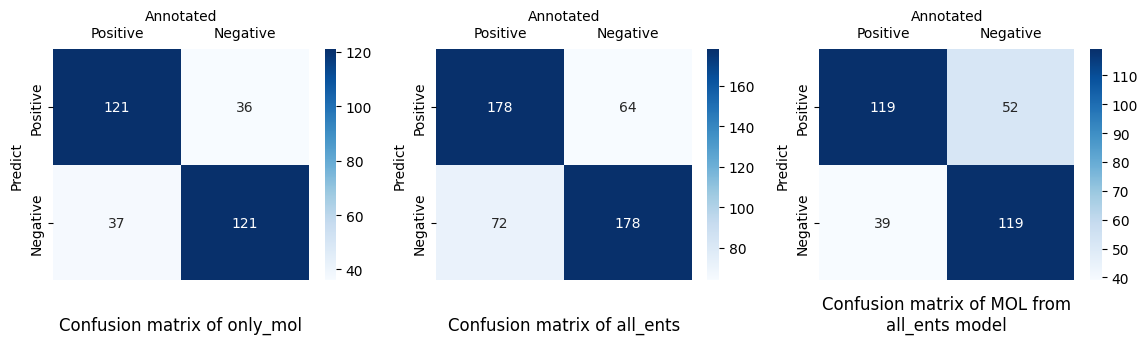

In [12]:
# Convert list of scores into a pd.DataFrame
df_cm = []
for i in range(len(parameters)) :
    df_cm.append(pd.DataFrame(
        [[tp[i], fp[i]], [fn[i], tn[i]]],
        index=["Positive", "Negative"],
        columns=["Positive", "Negative"]
    ))

# Display confusion matrix    
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for i, parms in enumerate(parameters):
    sns.heatmap(df_cm[i], annot=True, cmap='Blues', fmt='d', ax=axs[i])
    axs[i].set_xlabel('Annotated')
    axs[i].set_ylabel('Predict')
    title = "MOL from\n" + parms[0] + " model" if i == 2 else parms[0]
    axs[i].set_title("Confusion matrix of " +  title, y=-0.25)
    axs[i].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    axs[i].xaxis.set_label_position('top') 

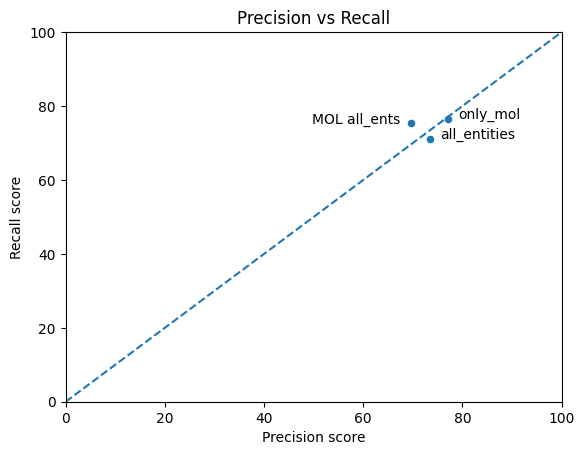

In [52]:
name_models = ["only_mol", "all_entities", "MOL all_ents"]
df = pd.DataFrame({"x":pscores, "y":rscores, "model":name_models})

# Plot different scores
ax = df.plot(kind='scatter', x='x', y='y')
plt.title("Precision vs Recall")
plt.plot([0, 100], [0, 100], linestyle="dashed")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("Precision score")
plt.ylabel("Recall score")

# Label each point in scatter plot
for idx, row in df.iterrows():
    if idx == 2:
        ax.annotate(row['model'], (row['x']-20, row['y']))
    else :
        ax.annotate(row['model'], (row['x'] + 2, row['y']))

## Entity Rulers

The [Entity Rulers](https://spacy.io/api/entityruler) can be useful if the corpus on which the model has been trained does not cover all the entities we are interested in, or if we wish to improve the performance of the model on a specific subset of entities, namely molecules. 

We listed a set of molecule names from the [PubChem](https://pubchem.ncbi.nlm.nih.gov/) database and defined them as our patterns for our Entity Rulers.  We have studied the performance with and without Entity Rulers as illustrated in the figures:

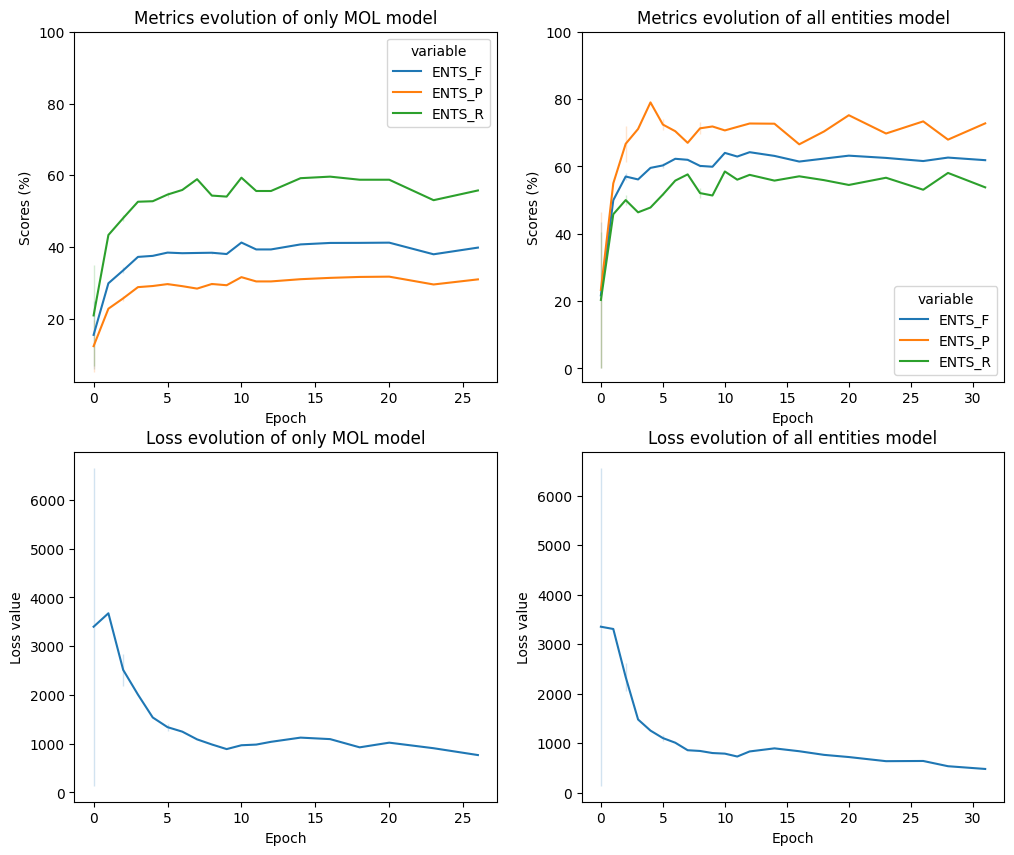

In [24]:
paths = ["../results/cpu_with_rulers.txt", "../results/cpu_without_rulers.txt"]
results = get_scores(paths)
display_plots(results)

In [13]:
bench_without = "MOL     51.96   64.63   57.61"
bench_with = "MOL      66.37   45.73   54.15"
pd.DataFrame([[66.37, 51.96]], columns=["Without rulers", "With rulers"], index=["MOL"])

,Without rulers,With rulers
MOL,66.37,51.96


We note a difference in the metrics during training. Indeed, it's important to note that the entity rules can sometimes lead to conflicts with the information learned by the model, which can result in poorer performance. It's important to carefully test and evaluate the effect of adding these entity rules on the performance of the model before using them.

## NER vs regular expression

The objective of this part is to compare our model using all entities with regular expressions, more precisely for entities like "STIME" (simulation time) and "TEMP" (temperature) which are easy to extract.

In [91]:
pattern = r"(\d+\.\d+|\d+)\s*([nμm]s)"
path = "../results/colab/all_ents"
ner = spacy.load(path + "/models/model-best/")
nlp = spacy.blank("en")
regex_time = 0
matchs_regex = []
ner_time = 0
matchs_ner = []
true_time = 0
annotated = []

# Read the evaluation dataset
with open(path + "/eval_data.spacy", "rb") as f:
    doc_bin = spacy.tokens.DocBin().from_bytes(f.read())
    
# Get predicted entities and annoted entities
for doc in doc_bin.get_docs(nlp.vocab):
    doc_ner = ner(doc.text)
    matchs = re.findall(pattern, doc.text)
    matchs_regex.extend(matchs)
    regex_time += len(matchs)
    pred_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc_ner.ents if ent.label_ == "STIME"]
    matchs_ner.extend(pred_ents)
    ner_time += len(pred_ents)
    true_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents if ent.label_ == "STIME"]
    annotated.extend(true_ents)
    true_time += len(true_ents)
print("NER: ", matchs_ner, "\n")
print("REGEX: ", matchs_regex, "\n")
print("ANNOTATED: ", annotated, "\n")
print("[STIME with NER]:", ner_time, " [STIME with REGEX]:", regex_time, " [STIME annotated]:", true_time)

NER:  [('100ns', 1302, 1307, 'STIME'), ('5 μs', 555, 559, 'STIME'), ('200 ns', 148, 154, 'STIME'), ('100 ns', 466, 472, 'STIME'), ('179 ns.', 683, 690, 'STIME'), ('15 μs', 78, 83, 'STIME'), ('15 μs', 1284, 1289, 'STIME'), ('10 μs', 1291, 1296, 'STIME'), ('5 μs', 1309, 1313, 'STIME'), ('4200 ns', 396, 403, 'STIME'), ('100 ns', 1010, 1016, 'STIME')] 

REGEX:  [('100', 'ns'), ('5', 'μs'), ('200', 'ns'), ('100', 'ns'), ('179', 'ns'), ('21', 'ns'), ('15', 'μs'), ('5', 'μs'), ('5', 'μs'), ('5', 'μs'), ('5', 'μs'), ('15', 'μs'), ('10', 'μs'), ('5', 'μs'), ('4200', 'ns'), ('100', 'ns')] 

ANNOTATED:  [('100ns', 1302, 1307, 'STIME'), ('5 μs', 555, 559, 'STIME'), ('200 ns', 148, 154, 'STIME'), ('179 ns', 683, 689, 'STIME'), ('15 μs', 78, 83, 'STIME'), ('4200 ns', 396, 403, 'STIME')] 

[STIME with NER]: 11  [STIME with REGEX]: 16  [STIME annotated]: 6


## Annex

In [53]:
#--------------------------------------------OUTPUTS--------------------------------------------#

benchmark_command_mol = """ MOL   77.07   76.58   76.83 """
benchmark_command_all = """
================================== Results ==================================

TOK     100.00
NER P   73.55 
NER R   71.20 
NER F   72.36 
SPEED   3554  


=============================== NER (per type) ===============================

             P       R       F
MOL      69.59   75.32   72.34
SOFT     95.00   61.29   74.51
FFM      83.87   59.09   69.33
STIME    45.45   83.33   58.82
TEMP    100.00   81.82   90.00
"""

<Figure size 500x500 with 0 Axes>

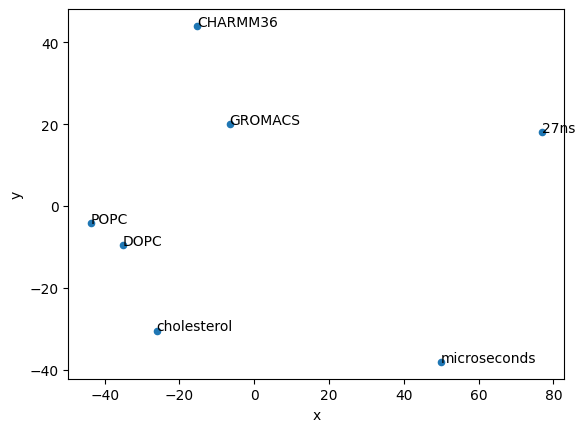

In [39]:
import numpy as np
import spacy
from sklearn.decomposition import PCA

nlp = spacy.load("../results/models_0.4_0.0_0.5_0.5/model-best/")

animals = """POPC DOPC cholesterol GROMACS CHARMM36 microseconds 27ns"""
tokens = nlp(animals)
vocab = animals.split()
vectors = np.vstack([word.vector for word in tokens])

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(vectors)
embeddings_df = pd.DataFrame({"x":embeddings_2d[:, 0], "y":embeddings_2d[:, 1], "token":vocab})

fig = plt.figure(figsize=(5, 5))

x_axis = embeddings_2d[:, 0]
y_axis = embeddings_2d[:, 1]

ax = embeddings_df.plot(kind='scatter', x='x', y='y')

#label each point in scatter plot
for idx, row in embeddings_df.iterrows():
    ax.annotate(row['token'], (row['x'], row['y']))